# Online Retail Sales Data

## Loading libraries

In [1]:

# Install packages
!pip install pandas numpy matplotlib seaborn scikit-learn scipy imbalanced-learn plotnine openpyxl

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.spatial.distance import cdist
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from plotnine import ggplot, aes, geom_line
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import openpyxl


## Introduction

**Objective**: This project aims to analyze an online retail sales database to identify customer segments and predict sales levels for each segment. By leveraging machine learning, the model aims to enhance business strategies through targeted marketing, optimized inventory management, and improved customer satisfaction.

* Note: This project was completed using Jupyter Notebook.

#### Customer Segmentation Benefits
* **Targeted Marketing:** Create campaigns tailored to specific groups, boosting engagement and conversions.
* **Enhanced Experience:** Personalize offers and communications based on detailed insights, increasing satisfaction and loyalty.
* **Efficient Resource Allocation:** Strategically allocate resources to maximize ROI using customer behavior data.
* **Informed Product Development:** Use customer insights to drive innovation and meet market needs.

#### Segmented Sales Prediction Benefits
* **Improved Inventory Forecasting:** Optimize stock levels, reducing overstock and stockouts.
* **Resource Planning:** Adjust budgets and pricing strategies to maximize sales during peak times.
* **Risk Management:** Anticipate market shifts and adjust strategies proactively to stay competitive.
* **Consumer Behavior Visualization:** Analyze behavior patterns to make informed decisions on product placements and campaigns.
* **Marketing Spend Optimization:** Direct budgets toward profitable segments to maximize ROI.
* **Effective Inventory Management:** Align stock with predicted demand to minimize inventory issues.
* **Targeted Discount Strategies:** Tailor discounts to specific segments based on buying behavior.
* **Competitive Positioning:** Analyze competitors to differentiate and gain a competitive advantage.

## Method and Results

### Loading Data

In [2]:
#Load data from a csv file

df = pd.read_csv('1SQL.csv')
print(df.head())

   Order_id    Purchase_time  Customer_id Product_category  Quantity   Price  \
0         1  2020/8/15 12:50            1   Home & Kitchen         3  394.67   
1         2  2020/8/16 12:50            2   Home & Kitchen         1  372.39   
2         3  2020/8/17 12:50            3   Home & Kitchen         7  243.14   
3         4  2020/8/18 12:50            4   Home & Kitchen         2   50.23   
4         5  2020/8/19 12:50            5   Home & Kitchen         2   60.82   

  Payment_method  Customer_age Customer_gender Customer_location  \
0      Gift Card            34          Female            Africa   
1    Credit Card            34            Male         Australia   
2    Credit Card            34           Other     North America   
3    Credit Card            34          Female         Australia   
4    Credit Card            34           Other         Australia   

   Full_purchase_amount  Discount Customer_income  Is_holiday  Unnamed: 14  \
0                698.57      0.1

### Data wrangling & cleaning & exploration (EDA)

In [3]:
# Display the shape of the dataset
print("Dataset shape:", df.shape)

# Summary statistics for numerical features
print("\nSummary Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Data types of the features
print("\nData Types:")
print(df.dtypes)

Dataset shape: (301425, 17)

Summary Statistics:
            Order_id    Customer_id       Quantity          Price  \
count  301425.000000  301425.000000  301425.000000  301425.000000   
mean   150713.000000  150713.000000       4.400647     252.397732   
std     87014.046783   87014.046783       2.778290     142.712736   
min         1.000000       1.000000       1.000000       5.000000   
25%     75357.000000   75357.000000       2.000000     129.250000   
50%    150713.000000  150713.000000       4.000000     252.110000   
75%    226069.000000  226069.000000       7.000000     375.450000   
max    301425.000000  301425.000000       9.000000     499.990000   

        Customer_age  Full_purchase_amount       Discount     Is_holiday  \
count  301425.000000         301425.000000  301425.000000  301425.000000   
mean       34.693476           1055.010118       0.132933       0.148063   
std        14.377372            950.932588       0.078924       0.355163   
min        15.000000     

In [4]:
# Remove the unwanted columns
df = df.drop(columns=['Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16'])

# Verify the columns have been removed by displaying the DataFrame's first few rows
print(df.head())

   Order_id    Purchase_time  Customer_id Product_category  Quantity   Price  \
0         1  2020/8/15 12:50            1   Home & Kitchen         3  394.67   
1         2  2020/8/16 12:50            2   Home & Kitchen         1  372.39   
2         3  2020/8/17 12:50            3   Home & Kitchen         7  243.14   
3         4  2020/8/18 12:50            4   Home & Kitchen         2   50.23   
4         5  2020/8/19 12:50            5   Home & Kitchen         2   60.82   

  Payment_method  Customer_age Customer_gender Customer_location  \
0      Gift Card            34          Female            Africa   
1    Credit Card            34            Male         Australia   
2    Credit Card            34           Other     North America   
3    Credit Card            34          Female         Australia   
4    Credit Card            34           Other         Australia   

   Full_purchase_amount  Discount Customer_income  Is_holiday  
0                698.57      0.15         0-25

In [5]:
# Make required changes after seeing the features 

# Convert 'Purchase_time' to datetime format
df['Purchase_time'] = pd.to_datetime(df['Purchase_time'], format='%Y/%m/%d %H:%M')

# Check the data type to confirm the conversion
print(df['Purchase_time'].dtypes)

datetime64[ns]


#### Feature Engineering

In [6]:
# Convert datetime to more specific time-based features 
df['Year'] = df['Purchase_time'].dt.year
df['Month'] = df['Purchase_time'].dt.month
df['Day'] = df['Purchase_time'].dt.day
df['Hour'] = df['Purchase_time'].dt.hour
df['Weekday'] = df['Purchase_time'].dt.weekday

# Group age to bins
bins = [0, 20, 30, 40, 50, 60, 87]
labels = ['0-20', '21-30', '31-40', '41-50', '51-60', '61-87']
df['Age_Range'] = pd.cut(df['Customer_age'], bins=bins, labels=labels, right=False)

# Now use 'Age_Range' in clustering instead of 'Customer_age'

# Ordinal encoding of categorical data 
product_category_encoder = LabelEncoder()
payment_method_encoder = LabelEncoder()
customer_location_encoder = LabelEncoder()
customer_gender_encoder = LabelEncoder()
customer_income_encoder = LabelEncoder()
age_range_encoder = LabelEncoder()

# use labels for categorical features in a DataFrame
df['Product_category_encoded'] = product_category_encoder.fit_transform(df['Product_category'])
df['Payment_method_encoded'] = payment_method_encoder.fit_transform(df['Payment_method'])
df['Customer_location_encoded'] = customer_location_encoder.fit_transform(df['Customer_location'])
df['Customer_gender_encoded'] = customer_gender_encoder.fit_transform(df['Customer_gender'])
df['Customer_income_encoded'] = customer_income_encoder.fit_transform(df['Customer_income'])
df['Age_encoded'] = age_range_encoder.fit_transform(df['Age_Range'])

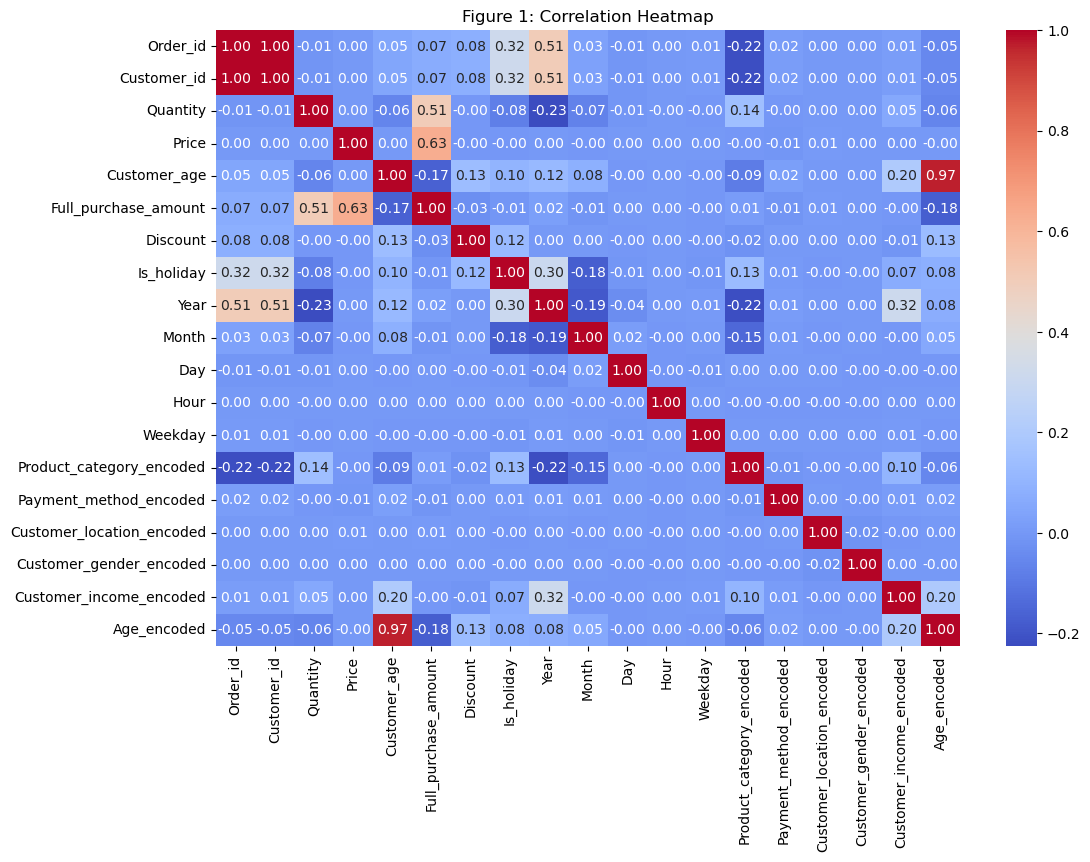

In [7]:
# Display heatmap to examine correlation 
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Figure 1: Correlation Heatmap')
plt.show()

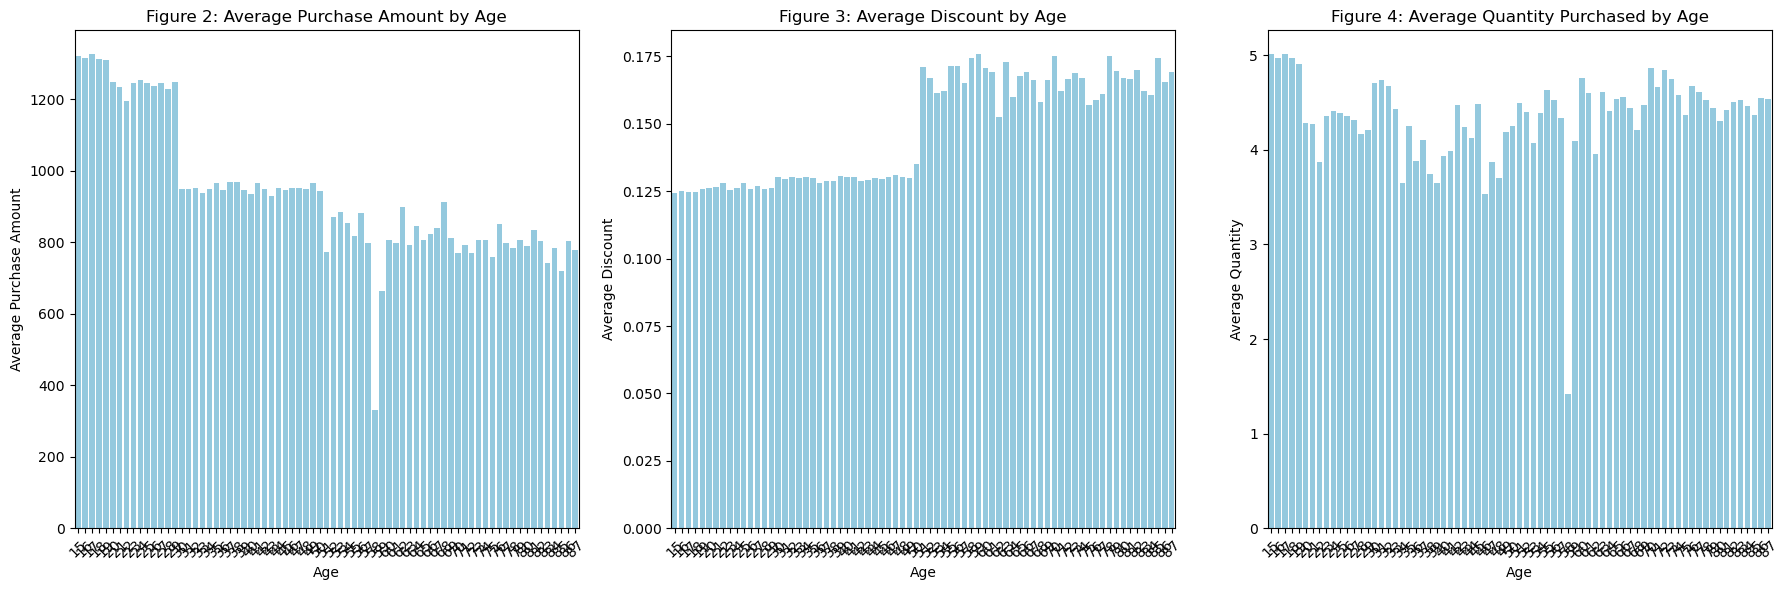

In [8]:
# Visualize Variable to select areas of interest 

#Subplots for Age vs. Purchase Amount, Discount, and Quantity 
age_summary = df.groupby('Customer_age').agg({
    'Full_purchase_amount': 'mean',
    'Discount': 'mean',
    'Quantity': 'mean'
}).reset_index()

# Set up the matplotlib figure
plt.figure(figsize=(18, 6))

# Subplot 1: Age vs. Purchase Amount
plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot
sns.barplot(data=age_summary, x='Customer_age', y='Full_purchase_amount', color='skyblue')
plt.title('Figure 2: Average Purchase Amount by Age')
plt.xlabel('Age')
plt.ylabel('Average Purchase Amount')
plt.xticks(rotation=45)

# Subplot 2: Age vs. Discount
plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
sns.barplot(data=age_summary, x='Customer_age', y='Discount', color='skyblue')
plt.title('Figure 3: Average Discount by Age')
plt.xlabel('Age')
plt.ylabel('Average Discount')
plt.xticks(rotation=45)

# Subplot 3: Age vs. Quantity
plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd subplot
sns.barplot(data=age_summary, x='Customer_age', y='Quantity', color='skyblue')
plt.title('Figure 4: Average Quantity Purchased by Age')
plt.xlabel('Age')
plt.ylabel('Average Quantity')
plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

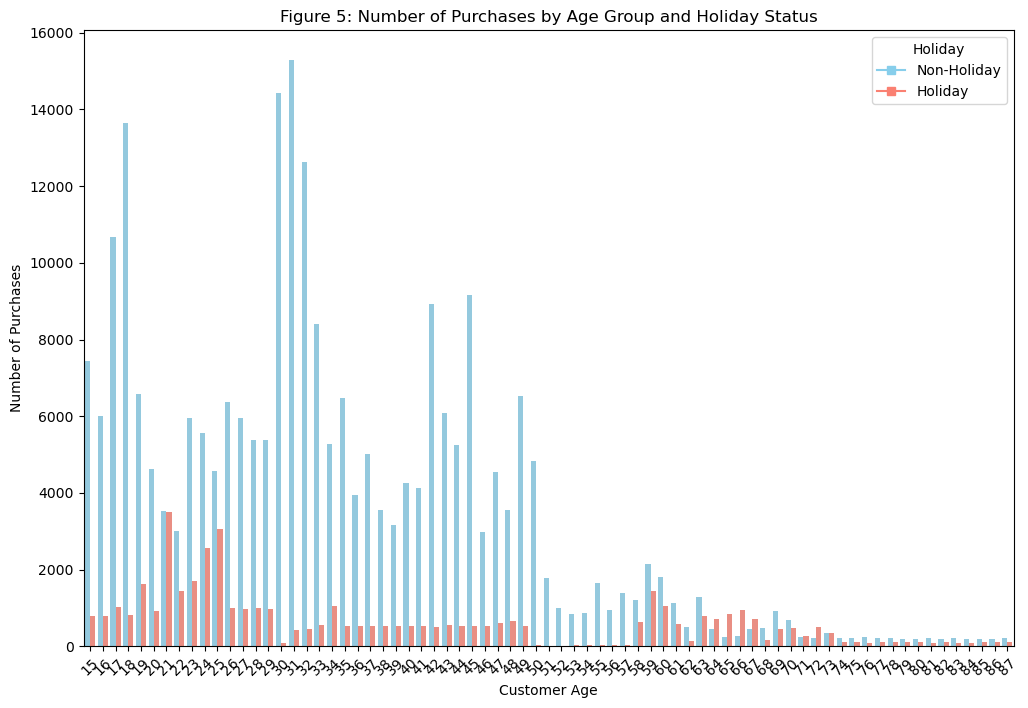

In [9]:
# Group by 'Customer_age' and 'Is_holiday', then count the 'Order_id'
age_holiday_purchases = df.groupby(['Customer_age', 'Is_holiday'])['Order_id'].count().reset_index()
age_holiday_purchases.rename(columns={'Order_id': 'Full_purchase_amount'}, inplace=True)

# Sort the DataFrame by 'Customer_age'
age_holiday_purchases = age_holiday_purchases.sort_values('Customer_age')

# Define the order of ages for the x-axis
age_order = sorted(age_holiday_purchases['Customer_age'].unique())

# Define color palette for hue
palette_colors = {False: 'skyblue', True: 'salmon'}  # False for Non-Holiday, True for Holiday

# Plotting
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=age_holiday_purchases, x='Customer_age', y='Full_purchase_amount', hue='Is_holiday',
            palette=palette_colors, order=age_order)
plt.title('Figure 5: Number of Purchases by Age Group and Holiday Status')
plt.xlabel('Customer Age')
plt.ylabel('Number of Purchases')

# Manually defining legend handles and labels
handles, labels = ax.get_legend_handles_labels()
labels = ['Non-Holiday', 'Holiday']
colors = ['skyblue', 'salmon']
new_handles = [plt.Line2D([], [], color=colors[i], marker='s') for i in range(len(handles))]
plt.legend(handles=new_handles, labels=labels, title='Holiday')
plt.xticks(rotation=45) 
plt.show()


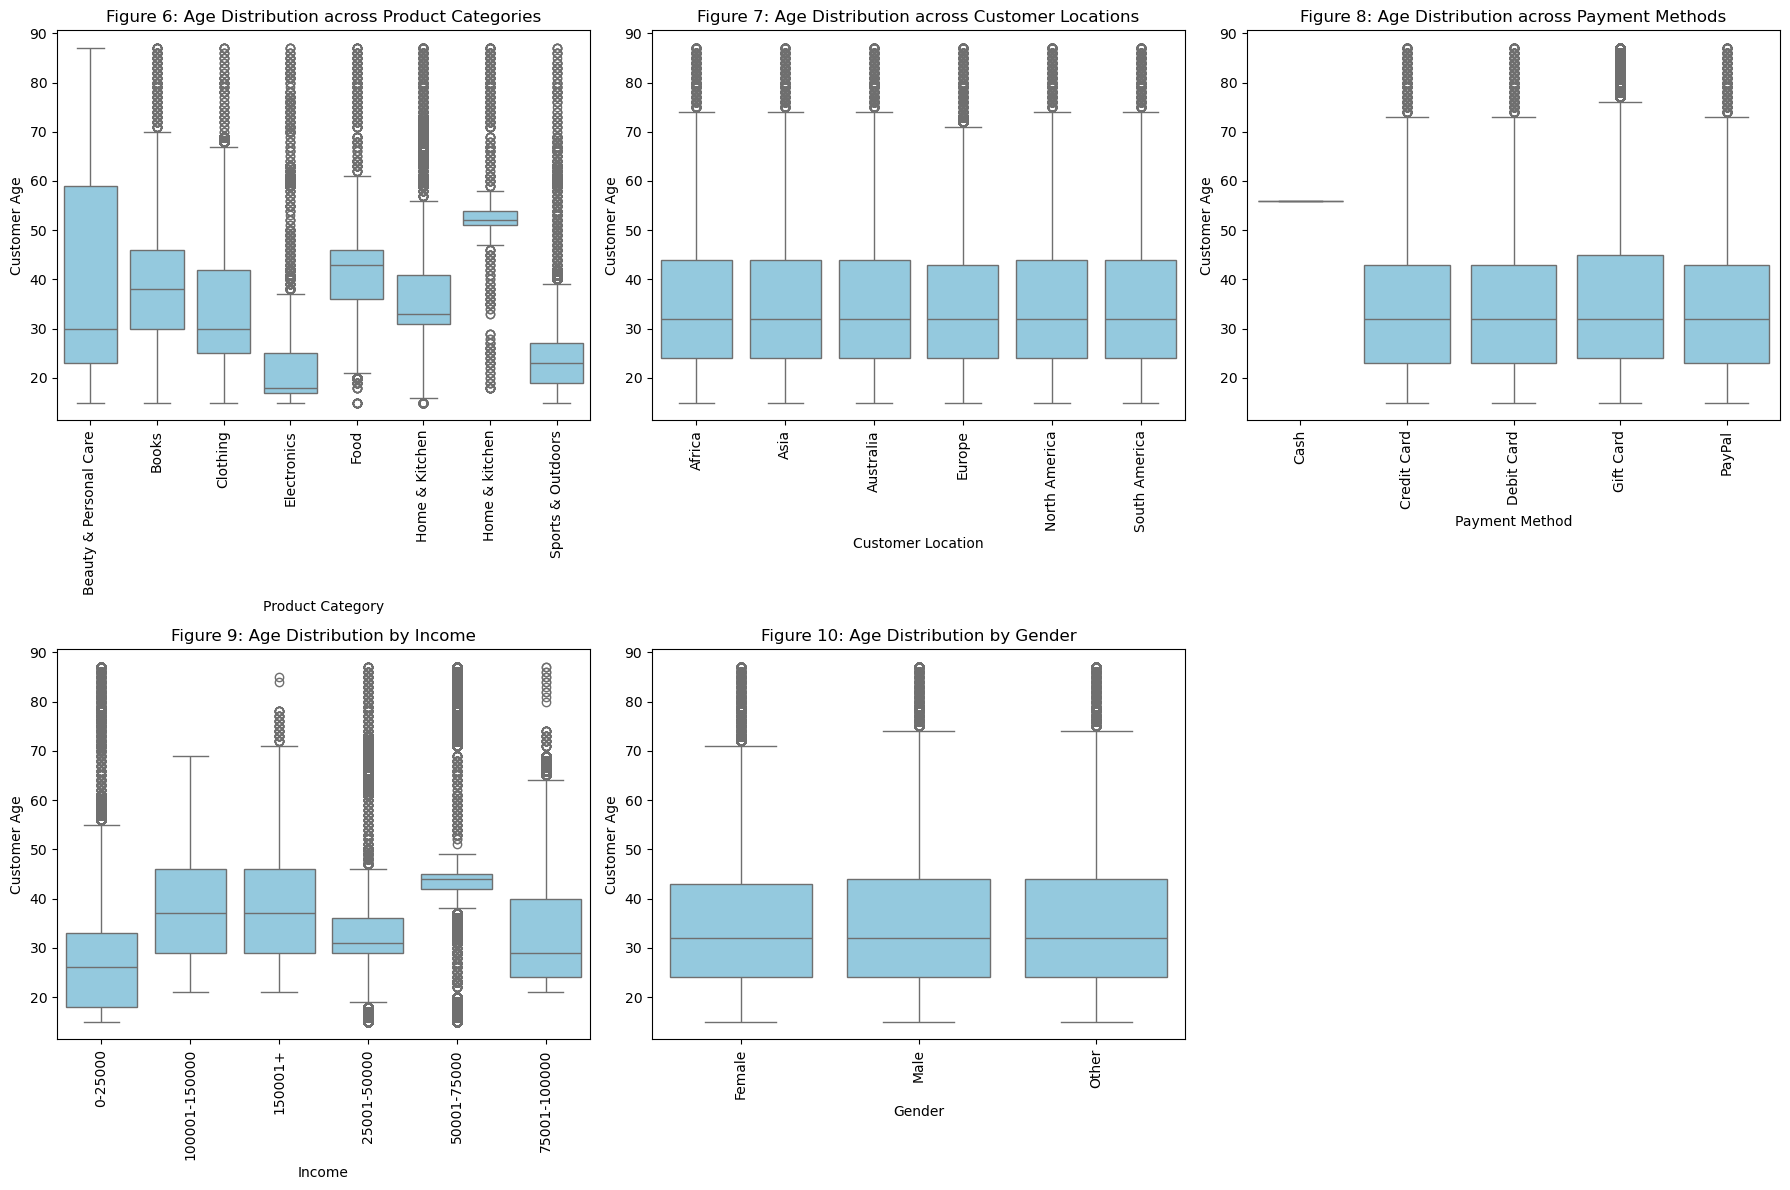

In [10]:
#Store the LabelEncoder for each categorical variable
label_encoders = {}
categories = ['Product_category', 'Payment_method', 'Customer_location', 'Customer_gender', 'Customer_income']

for cat in categories:
    le = LabelEncoder()
    df[cat + '_encoded'] = le.fit_transform(df[cat])
    label_encoders[cat] = le

#Plot
plt.figure(figsize=(18, 12))

# Subplot 1: Age vs. Product Category
plt.subplot(2, 3, 1)
sns.boxplot(data=df, x='Product_category_encoded', y='Customer_age', color='skyblue')
plt.title('Figure 6: Age Distribution across Product Categories')
plt.xlabel('Product Category')
plt.ylabel('Customer Age')
plt.xticks(range(len(label_encoders['Product_category'].classes_)), label_encoders['Product_category'].inverse_transform(range(len(label_encoders['Product_category'].classes_))), rotation=90)

# Subplot 2: Age vs. Customer Location
plt.subplot(2, 3, 2)
sns.boxplot(data=df, x='Customer_location_encoded', y='Customer_age', color='skyblue')
plt.title('Figure 7: Age Distribution across Customer Locations')
plt.xlabel('Customer Location')
plt.ylabel('Customer Age')
plt.xticks(range(len(label_encoders['Customer_location'].classes_)), label_encoders['Customer_location'].inverse_transform(range(len(label_encoders['Customer_location'].classes_))), rotation=90)

# Subplot 3: Age vs. Payment Method
plt.subplot(2, 3, 3)
sns.boxplot(data=df, x='Payment_method_encoded', y='Customer_age', color='skyblue')
plt.title('Figure 8: Age Distribution across Payment Methods')
plt.xlabel('Payment Method')
plt.ylabel('Customer Age')
plt.xticks(range(len(label_encoders['Payment_method'].classes_)), label_encoders['Payment_method'].inverse_transform(range(len(label_encoders['Payment_method'].classes_))), rotation=90)

# Subplot 4: Age vs. Income
plt.subplot(2, 3, 4)
sns.boxplot(data=df, x='Customer_income_encoded', y='Customer_age', color='skyblue')
plt.title('Figure 9: Age Distribution by Income')
plt.xlabel('Income')
plt.ylabel('Customer Age')
plt.xticks(range(len(label_encoders['Customer_income'].classes_)), label_encoders['Customer_income'].inverse_transform(range(len(label_encoders['Customer_income'].classes_))), rotation=90)

# Subplot 5: Age vs. Gender
plt.subplot(2, 3, 5)
sns.boxplot(data=df, x='Customer_gender_encoded', y='Customer_age', color='skyblue')
plt.title('Figure 10: Age Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Customer Age')
plt.xticks(range(len(label_encoders['Customer_gender'].classes_)), label_encoders['Customer_gender'].inverse_transform(range(len(label_encoders['Customer_gender'].classes_))), rotation=90)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## Customer Segmentation Model (Unsupervised Learning)

In [11]:
#Normalize data
from sklearn.preprocessing import StandardScaler

# Selecting the data
data_to_cluster = df[['Full_purchase_amount', 'Age_encoded', 'Product_category_encoded']]

# Normalizing the data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_to_cluster)

In [12]:
# Apply K-means clustering
kmeans = KMeans(n_clusters=3,  n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(data_normalized)

# Adding the cluster labels to your DataFrame for later analysis
df['Cluster_Labels'] = cluster_labels

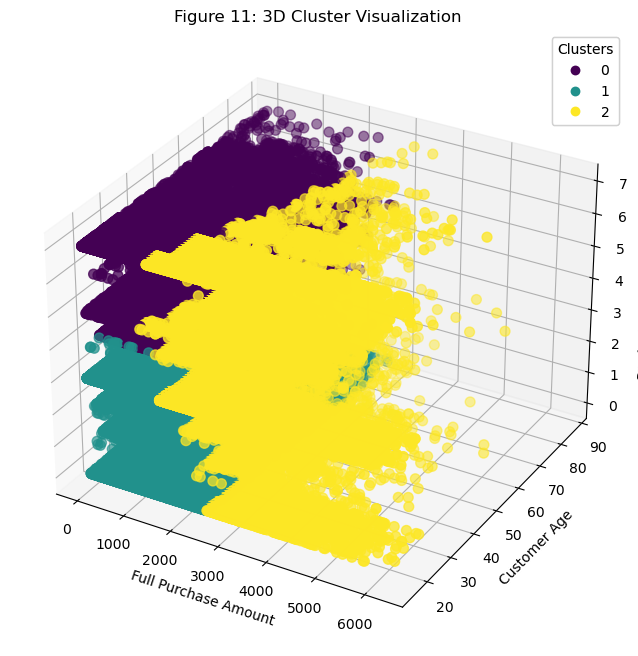

In [13]:
#Visualize the graph 

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df['Full_purchase_amount'],
                     df['Customer_age'],
                     df['Product_category_encoded'],
                     c=df['Cluster_Labels'], s=50, cmap='viridis')

# Adding labels and title
ax.set_xlabel('Full Purchase Amount')
ax.set_ylabel('Customer Age')
ax.set_zlabel('Product Category Encoded')
ax.set_title('Figure 11: 3D Cluster Visualization')

# Legend for clusters
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)

plt.show()


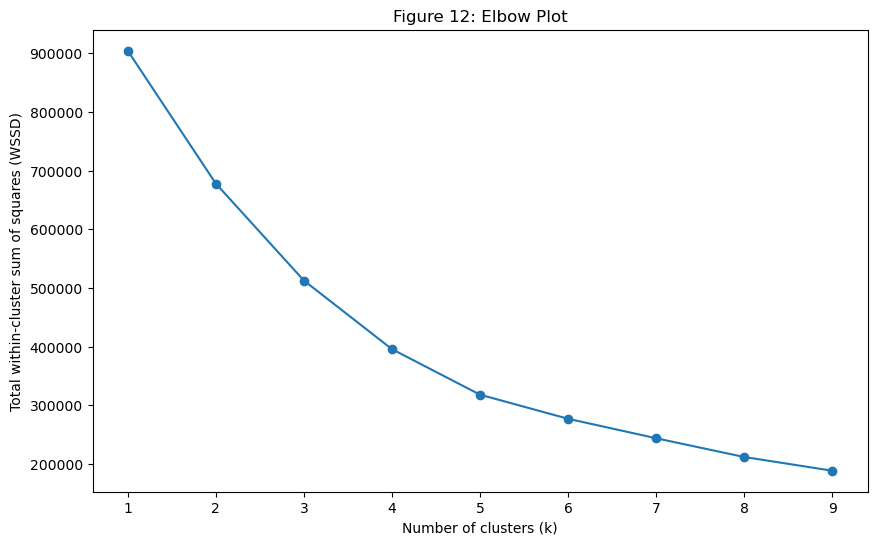

In [14]:
#Visualize elbow graph to identify optimal k

wssd = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(data_normalized)
    wssd.append(kmeans.inertia_)  # Inertia: Sum of squared distances of samples to their closest cluster center

plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), wssd, marker='o')
plt.title('Figure 12: Elbow Plot')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Total within-cluster sum of squares (WSSD)')
plt.xticks(range(1, 10))
plt.show()

In [15]:
# cluster the data into 4 groups, as determined by the optimal k

optimal_k = 4
final_kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
final_kmeans.fit(data_normalized)
df['Optimal_Cluster_Labels'] = final_kmeans.labels_

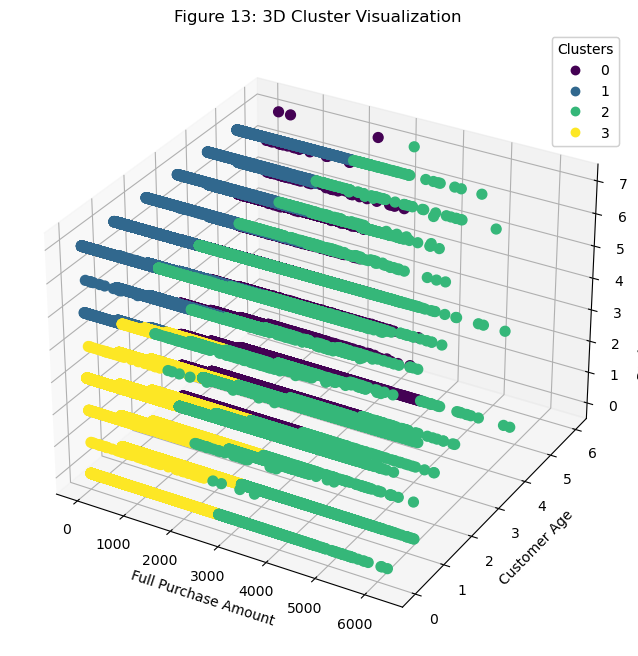

In [16]:
#Visualize the clusters with the optimal k

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df['Full_purchase_amount'],
                     df['Age_encoded'],
                     df['Product_category_encoded'],
                     c=df['Optimal_Cluster_Labels'], s=50, cmap='viridis', depthshade=False)

# Adding labels and title
ax.set_xlabel('Full Purchase Amount')
ax.set_ylabel('Customer Age')
ax.set_zlabel('Product Category Encoded')
ax.set_title('Figure 13: 3D Cluster Visualization')

# Legend for clusters
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)

plt.show()

In [17]:
## Display summary statistics of the model

# Suppose this is the initial fitting of the encoder
label_encoder = LabelEncoder()
df['Product_category_encoded'] = label_encoder.fit_transform(df['Product_category'])
df['Age_encoded'] = label_encoder.fit_transform(df['Age_Range'])

# Check what categories are transformed to ensure correct mapping
print("Encoded categories:", label_encoder.classes_)

# Define a custom function to find the top two frequent categories and return their names as a single string
def top_two_modes(encoder, x):
    counts = x.value_counts()
    top_modes_indices = counts.nlargest(2).index.tolist()
    if len(top_modes_indices) < 2:
        top_modes_indices.append(np.nan)  # Append NaN if there's less than 2 unique values
    # Decode the top two modes to return the category names
    top_modes_names = encoder.inverse_transform([int(i) for i in top_modes_indices if pd.notna(i)])
    # Join the top two modes with a comma
    return ', '.join(top_modes_names)
    
# Aggregations for the groupby operation
aggregations = {
    'Full_purchase_amount': [lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)],
    'Product_category_encoded': lambda x: top_two_modes(product_category_encoder, x),
    'Age_encoded': lambda x: top_two_modes(age_range_encoder, x)  # if you also want to get mode info for age ranges
}


# Apply custom aggregation rules
cluster_summary = df.groupby('Optimal_Cluster_Labels').agg(aggregations)

# Flatten the column names if necessary
cluster_summary.columns = ['_'.join(col).strip() for col in cluster_summary.columns.values]

print(cluster_summary)

Encoded categories: ['0-20' '21-30' '31-40' '41-50' '51-60' '61-87' nan]
                        Full_purchase_amount_<lambda_0>  \
Optimal_Cluster_Labels                                    
0                                             217.29940   
1                                             250.85000   
2                                            2118.91680   
3                                             307.16784   

                        Full_purchase_amount_<lambda_1>  \
Optimal_Cluster_Labels                                    
0                                            1134.36810   
1                                            1028.83000   
2                                            3108.33460   
3                                            1203.59172   

                             Product_category_encoded_<lambda>  \
Optimal_Cluster_Labels                                           
0                       Beauty & Personal Care, Home & Kitchen   
1                  

#### Results

Clusters Identified: The unsupervised learning model identified four optimal clusters based on customer demographics and purchasing behavior (see Figure 13), as suggested by the elbow method (see Figure 12). Each cluster represents a distinct segment of the customer base, characterized by age groups and product category preferences:

* Cluster 0 (Ages 51-87): Beauty & Personal Care, Home & Kitchen
* Cluster 1 (Ages 31-50): Home & Kitchen, Food
* Cluster 2 (Ages 21-40):  Electronics, Food
* Cluster 3 (Ages 0-30): Electronics, Beauty & Personal Care 

## Sales Prediction (Supervised Learning) - Linear Regression

In [18]:
print(df.columns)

Index(['Order_id', 'Purchase_time', 'Customer_id', 'Product_category',
       'Quantity', 'Price', 'Payment_method', 'Customer_age',
       'Customer_gender', 'Customer_location', 'Full_purchase_amount',
       'Discount', 'Customer_income', 'Is_holiday', 'Year', 'Month', 'Day',
       'Hour', 'Weekday', 'Age_Range', 'Product_category_encoded',
       'Payment_method_encoded', 'Customer_location_encoded',
       'Customer_gender_encoded', 'Customer_income_encoded', 'Age_encoded',
       'Cluster_Labels', 'Optimal_Cluster_Labels'],
      dtype='object')


In [19]:
# Correlation matrix to find relevant features

# Select only numeric columns from the DataFrame
numeric_df = df.select_dtypes(include=[np.number])

# Calculate the correlation matrix for numeric data only
correlation_matrix = numeric_df.corr()
print(correlation_matrix['Full_purchase_amount'].sort_values(ascending=False))

Full_purchase_amount         1.000000
Cluster_Labels               0.669365
Price                        0.629578
Quantity                     0.505954
Optimal_Cluster_Labels       0.199750
Customer_id                  0.066948
Order_id                     0.066948
Year                         0.022789
Product_category_encoded     0.012957
Customer_location_encoded    0.006449
Customer_gender_encoded      0.003406
Hour                         0.001570
Day                          0.000694
Weekday                     -0.001134
Customer_income_encoded     -0.002042
Is_holiday                  -0.007550
Payment_method_encoded      -0.009993
Month                       -0.013436
Discount                    -0.031287
Customer_age                -0.167370
Age_encoded                 -0.176713
Name: Full_purchase_amount, dtype: float64


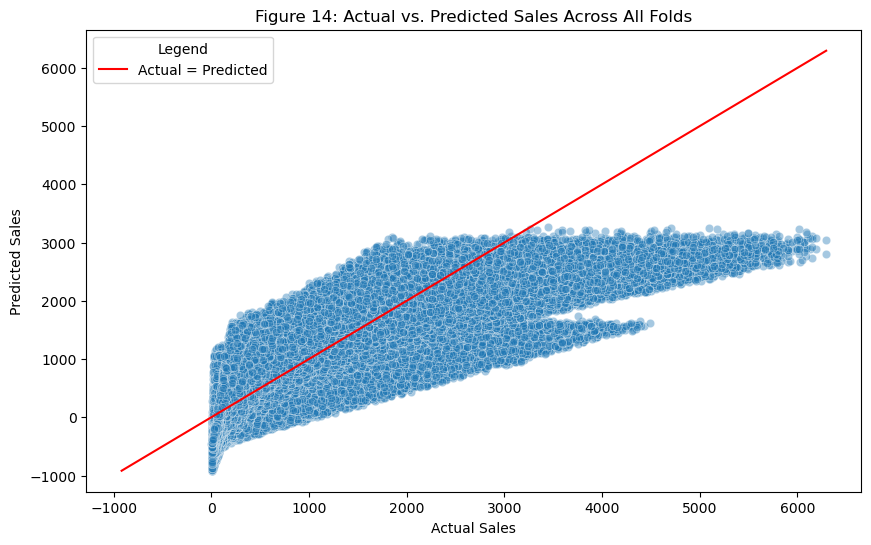

Cross-Validated RMSE scores: [549.9164634311707, 545.4416391902482, 544.6401111428601, 546.3309513042561, 547.1693526331694]
Average RMSE: 546.6997035403408


In [20]:
# Full sales kfolds 

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

X = df[['Price', 'Quantity', 'Year', 'Hour', 'Discount', 'Is_holiday']]
y = df['Full_purchase_amount']

# K-Folds Cross-Validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model = LinearRegression()

# Lists to store results for plotting
Armse_scores = []
predictions_list = []
actuals_list = []

# Cross-validation loop
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    Armse_scores.append(rmse)
    
    predictions_list.extend(predictions)  # For plotting
    actuals_list.extend(y_test)  # For plotting

# Plotting results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=actuals_list, y=predictions_list, alpha=0.4)
line_range = [min(actuals_list + predictions_list), max(actuals_list + predictions_list)]
sns.lineplot(x=line_range, y=line_range, color='red', label='Actual = Predicted')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Figure 14: Actual vs. Predicted Sales Across All Folds')
plt.legend(title='Legend')
plt.show()

# Print RMSE scores
print(f'Cross-Validated RMSE scores: {Armse_scores}')
print(f'Average RMSE: {np.mean(Armse_scores)}')

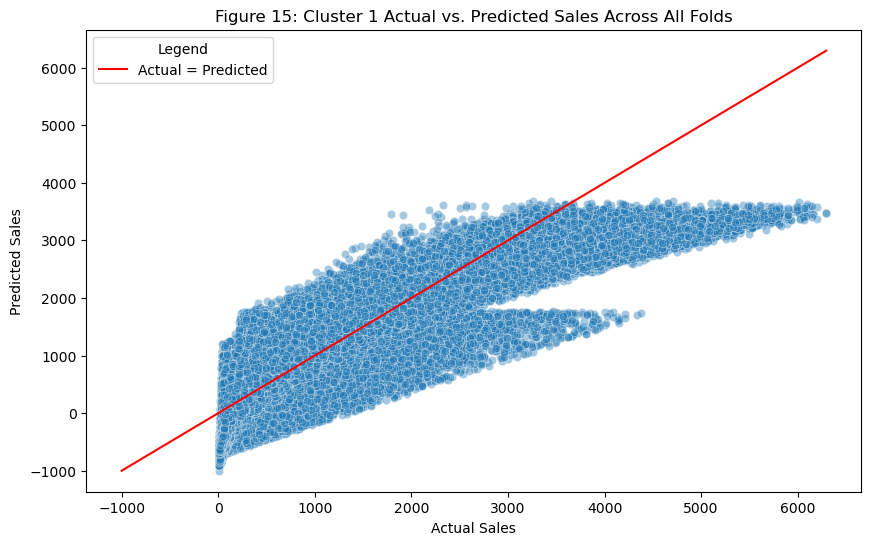

Cross-Validated RMSE scores: [553.0819003591179, 561.1345752328291, 552.6385685052288, 561.8074480749974, 557.5561093197932]
Average RMSE: 557.2437202983932


In [21]:
# Cluster 1 kfolds 

df_cluster1 = df[df['Age_Range'].isin(['0-20', '21-30'])]

# Selecting data for modeling
X = df_cluster1[['Price', 'Quantity', 'Year', 'Hour', 'Discount', 'Is_holiday']]
y = df_cluster1['Full_purchase_amount']

# K-Folds setup
kf = KFold(n_splits=5, random_state=42, shuffle=True)
model = LinearRegression()

# Lists to store results for plotting
A1rmse_scores = []
predictions_list = []
actuals_list = []

# Cross-validation loop
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    A1rmse_scores.append(rmse)
    predictions_list.extend(predictions)  # For plotting
    actuals_list.extend(y_test)  # For plotting

# Plotting results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=actuals_list, y=predictions_list, alpha=0.4)
line_range = [min(actuals_list + predictions_list), max(actuals_list + predictions_list)]
sns.lineplot(x=line_range, y=line_range, color='red', label='Actual = Predicted')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Figure 15: Cluster 1 Actual vs. Predicted Sales Across All Folds')
plt.legend(title='Legend')
plt.show()


# Print RMSE scores
print(f'Cross-Validated RMSE scores: {A1rmse_scores}')
print(f'Average RMSE: {np.mean(A1rmse_scores)}')

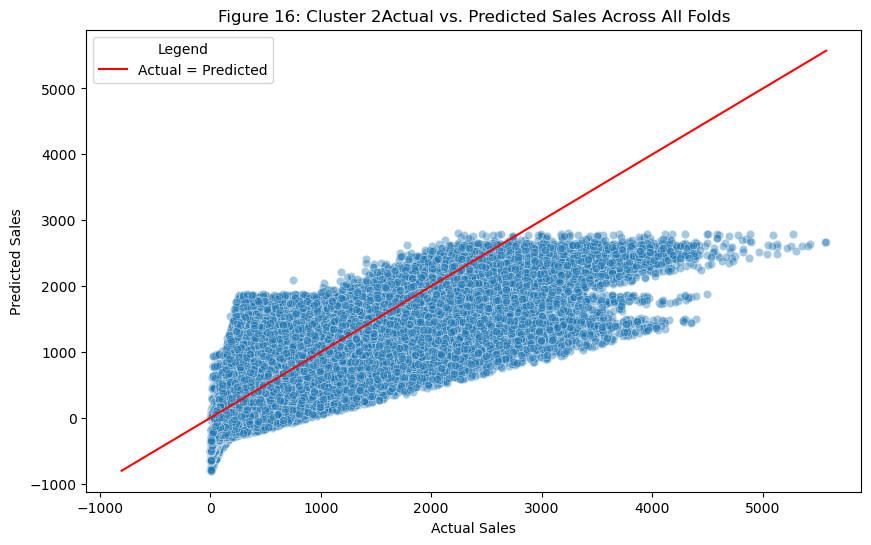

Cross-Validated RMSE scores: [455.52852995727807, 456.3815841000054, 458.86445112290625, 458.4717026598188, 462.5689252700881]
Average RMSE: 458.3630386220193


In [22]:
# Cluster 2 kfolds

df_cluster2 = df[df['Age_Range'].isin(['31-40', '41-50'])]

# Selecting data for modeling
X = df_cluster2[['Price', 'Quantity', 'Year', 'Hour', 'Discount', 'Is_holiday']]
y = df_cluster2['Full_purchase_amount']


# K-Folds setup
kf = KFold(n_splits=5, random_state=42, shuffle=True)
model = LinearRegression()

# Lists to store results for plotting
A2rmse_scores = []
predictions_list = []
actuals_list = []

# Cross-validation loop
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    A2rmse_scores.append(rmse)
    predictions_list.extend(predictions)  # For plotting
    actuals_list.extend(y_test)  # For plotting

# Plotting results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=actuals_list, y=predictions_list, alpha=0.4)
line_range = [min(actuals_list + predictions_list), max(actuals_list + predictions_list)]
sns.lineplot(x=line_range, y=line_range, color='red', label='Actual = Predicted')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Figure 16: Cluster 2Actual vs. Predicted Sales Across All Folds')
plt.legend(title='Legend')
plt.show()

# Print RMSE scores
print(f'Cross-Validated RMSE scores: {A2rmse_scores}')
print(f'Average RMSE: {np.mean(A2rmse_scores)}')

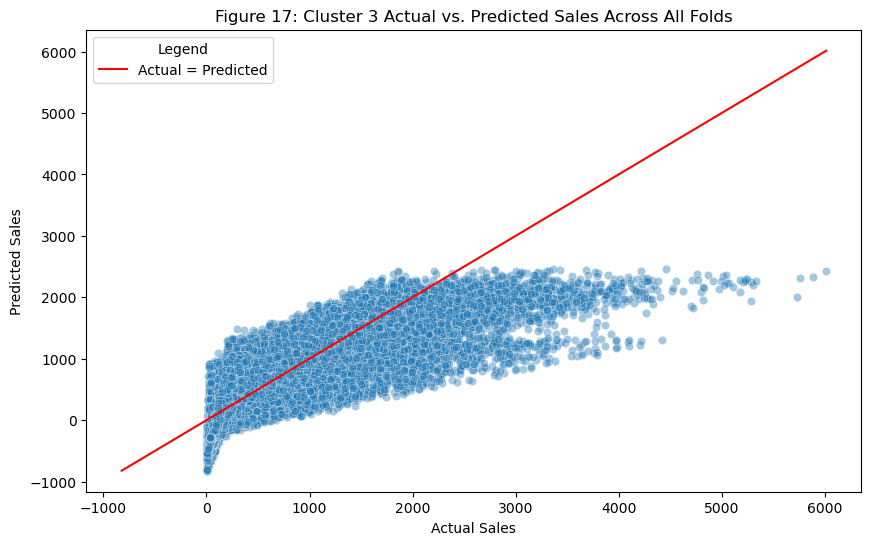

Cross-Validated RMSE scores: [448.5237638923869, 436.4219310444445, 444.5925182188577, 437.99947040198623, 427.89301229976394]
Average RMSE: 439.08613917148784


In [23]:
# Cluster 3 kfolds 

df_cluster3 = df[df['Age_Range'].isin(['51-60', '61-87'])]

# Selecting data for modeling
X = df_cluster3[['Price', 'Quantity', 'Year', 'Hour', 'Discount', 'Is_holiday']]
y = df_cluster3['Full_purchase_amount']

# K-Folds setup
kf = KFold(n_splits=5, random_state=42, shuffle=True)
model = LinearRegression()

# Lists to store results for plotting
A3rmse_scores = []
predictions_list = []
actuals_list = []

# Cross-validation loop
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    A3rmse_scores.append(rmse)
    
    predictions_list.extend(predictions)  # For plotting
    actuals_list.extend(y_test)  # For plotting

# Plotting results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=actuals_list, y=predictions_list, alpha=0.4)
line_range = [min(actuals_list + predictions_list), max(actuals_list + predictions_list)]
sns.lineplot(x=line_range, y=line_range, color='red', label='Actual = Predicted')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Figure 17: Cluster 3 Actual vs. Predicted Sales Across All Folds')
plt.legend(title='Legend')
plt.show()

# Print RMSE scores
print(f'Cross-Validated RMSE scores: {A3rmse_scores}')
print(f'Average RMSE: {np.mean(A3rmse_scores)}')

## Random Forest Sales Prediction 

In [24]:
#Using Random Forest to see if we can reduce the RMSE -> Non linear relationships 

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score

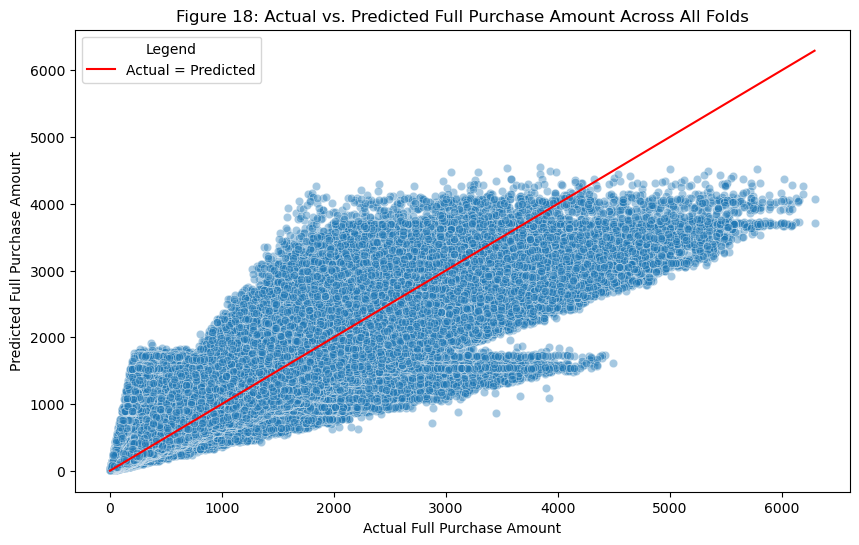

Cross-Validated RMSE scores: [429.2298187834211, 427.9918794397498, 428.292448247913, 426.79238545693175, 429.4866905440316]
Average RMSE: 428.3586444944094


In [25]:
#Full model 

# Selecting data for modeling
X = df[['Price', 'Quantity', 'Year', 'Hour', 'Discount', 'Is_holiday']]
y = df['Full_purchase_amount']  # Full_purchase_amount is the target (sales)

# K-Folds Cross-Validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Create the Random Forest model
rf_model = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)

# Lists to store results for final plotting and RMSE calculation
all_predictions = []
all_actuals = []
Brmse_scores = []

# Loop to process each fold
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    rf_model.fit(X_train, y_train)
    predictions = rf_model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    Brmse_scores.append(rmse)
    
    # Store predictions and actuals for final plot
    all_predictions.extend(predictions)
    all_actuals.extend(y_test)

# Plotting actual vs. predicted values for all data points across all folds
plt.figure(figsize=(10, 6))
sns.scatterplot(x=all_actuals, y=all_predictions, alpha=0.4)
line_range = [min(all_actuals), max(all_actuals)]
sns.lineplot(x=line_range, y=line_range, color='red', label='Actual = Predicted')
plt.xlabel('Actual Full Purchase Amount')
plt.ylabel('Predicted Full Purchase Amount')
plt.title('Figure 18: Actual vs. Predicted Full Purchase Amount Across All Folds')
plt.legend(title='Legend')
plt.show()

# Print RMSE scores and average
print(f'Cross-Validated RMSE scores: {Brmse_scores}')
print(f'Average RMSE: {np.mean(Brmse_scores)}')


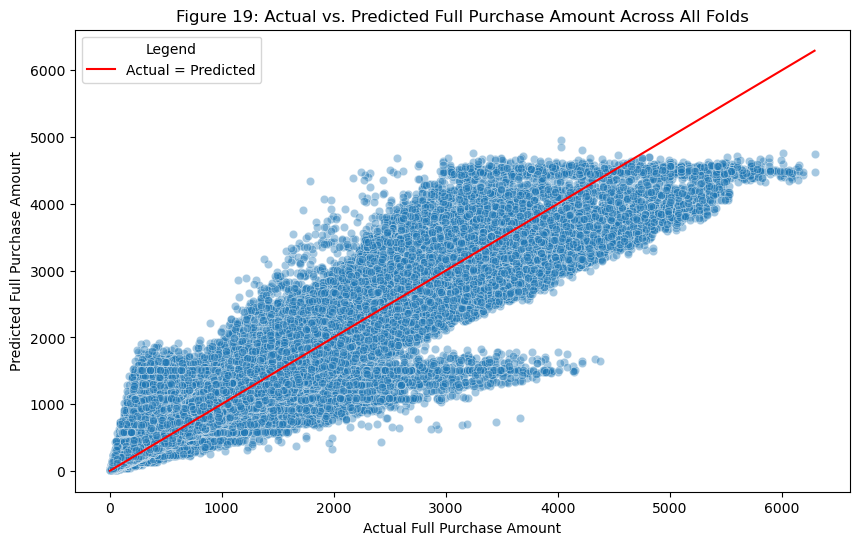

Cross-Validated RMSE scores: [387.66853537130436, 393.7355261738371, 390.9006542548435, 395.42940764753513, 397.19781286185184]
Average RMSE: 392.98638726187437


In [26]:
#Cluster 1 k folds

df_cluster1 = df[df['Age_Range'].isin(['0-20', '21-30'])]

# Selecting data for modeling
X = df_cluster1[['Price', 'Quantity', 'Year', 'Hour', 'Discount', 'Is_holiday']]
y = df_cluster1['Full_purchase_amount']

# K-Folds Cross-Validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Create the Random Forest model
rf_model = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)

# Lists to store results for final plotting and RMSE calculation
all_predictions = []
all_actuals = []
B1rmse_scores = []

# Loop to process each fold
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    rf_model.fit(X_train, y_train)
    predictions = rf_model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    B1rmse_scores.append(rmse)
    
    # Store predictions and actuals for final plot
    all_predictions.extend(predictions)
    all_actuals.extend(y_test)

# Plotting actual vs. predicted values for all data points across all folds
plt.figure(figsize=(10, 6))
sns.scatterplot(x=all_actuals, y=all_predictions, alpha=0.4)
line_range = [min(all_actuals), max(all_actuals)]
sns.lineplot(x=line_range, y=line_range, color='red', label='Actual = Predicted')
plt.xlabel('Actual Full Purchase Amount')
plt.ylabel('Predicted Full Purchase Amount')
plt.title('Figure 19: Actual vs. Predicted Full Purchase Amount Across All Folds')
plt.legend(title='Legend')
plt.show()

# Print RMSE scores and average
print(f'Cross-Validated RMSE scores: {B1rmse_scores}')
print(f'Average RMSE: {np.mean(B1rmse_scores)}')


In [27]:
# Creating a DataFrame from actual and predicted values for the Tableau Visualization
results_df = pd.DataFrame({
    'Actual': all_actuals,
    'Predicted': all_predictions
})

# Saving the DataFrame to a CSV file
results_df.to_csv('/home/jupyter/SQL-project/rf_predictions.csv', index=False)

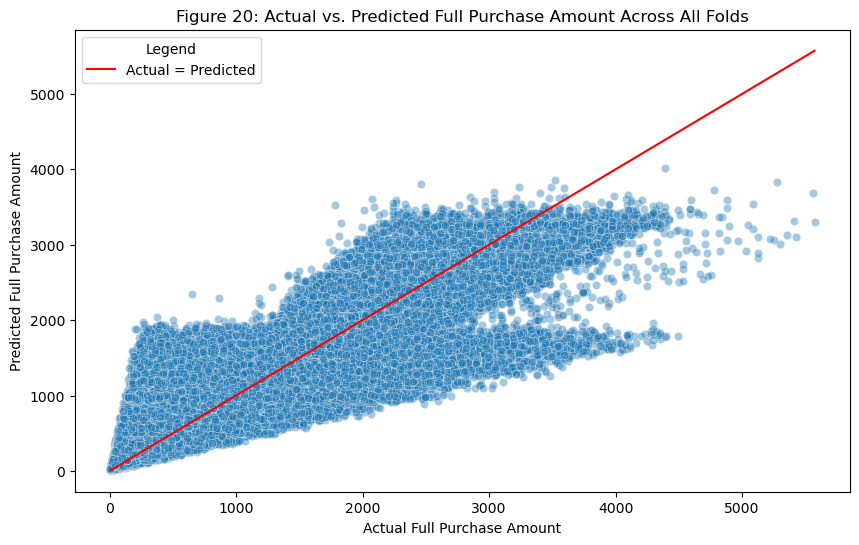

Cross-Validated RMSE scores: [349.93074093928954, 349.3869577070663, 351.1766929207938, 351.0593982830886, 354.6942146434944]
Average RMSE: 351.24960089874656


In [28]:
#Cluster 2 k folds

df_cluster2 = df[df['Age_Range'].isin(['31-40', '41-50'])]

# Selecting data for modeling
X = df_cluster2[['Price', 'Quantity', 'Year', 'Hour', 'Discount', 'Is_holiday']]
y = df_cluster2['Full_purchase_amount']

# K-Folds Cross-Validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Create the Random Forest model
rf_model = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)

# Lists to store results for final plotting and RMSE calculation
all_predictions = []
all_actuals = []
B2rmse_scores = []

# Loop to process each fold
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    rf_model.fit(X_train, y_train)
    predictions = rf_model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    B2rmse_scores.append(rmse)
    
    # Store predictions and actuals for final plot
    all_predictions.extend(predictions)
    all_actuals.extend(y_test)

# Plotting actual vs. predicted values for all data points across all folds
plt.figure(figsize=(10, 6))
sns.scatterplot(x=all_actuals, y=all_predictions, alpha=0.4)
line_range = [min(all_actuals), max(all_actuals)]
sns.lineplot(x=line_range, y=line_range, color='red', label='Actual = Predicted')
plt.xlabel('Actual Full Purchase Amount')
plt.ylabel('Predicted Full Purchase Amount')
plt.title('Figure 20: Actual vs. Predicted Full Purchase Amount Across All Folds')
plt.legend(title='Legend')
plt.show()

# Print RMSE scores and average
print(f'Cross-Validated RMSE scores: {B2rmse_scores}')
print(f'Average RMSE: {np.mean(B2rmse_scores)}')


In [29]:
# Creating a DataFrame from actual and predicted values for the Tableau Visualization
results_df = pd.DataFrame({
    'Actual': all_actuals,
    'Predicted': all_predictions
})

# Saving the DataFrame to a CSV file
results_df.to_csv('/home/jupyter/SQL-project/2rf_predictions.csv', index=False)

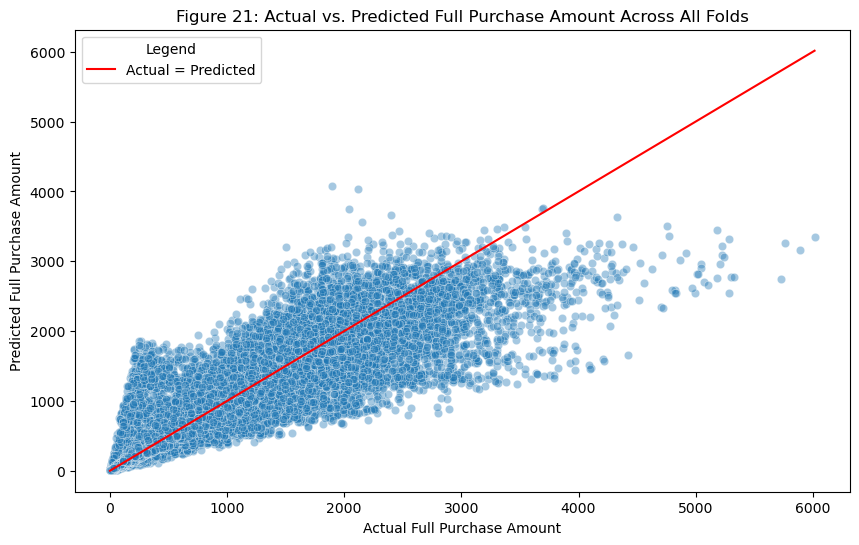

Cross-Validated RMSE scores: [343.74818436048946, 338.3465625705447, 343.02911534366376, 340.1985819677995, 326.8297220650665]
Average RMSE: 338.4304332615128


In [30]:
#Cluster 3 k folds

# Create cluster based on age range
df_cluster3 = df[df['Age_Range'].isin(['51-60', '61-87'])]

# Selecting data for modeling
X = df_cluster3[['Price', 'Quantity', 'Year', 'Hour', 'Discount', 'Is_holiday']]
y = df_cluster3['Full_purchase_amount']

# K-Folds Cross-Validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Create the Random Forest model
rf_model = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)

# Lists to store results for final plotting and RMSE calculation
all_predictions = []
all_actuals = []
B3rmse_scores = []

# Loop to process each fold
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    rf_model.fit(X_train, y_train)
    predictions = rf_model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    B3rmse_scores.append(rmse)
    
    # Store predictions and actuals for final plot
    all_predictions.extend(predictions)
    all_actuals.extend(y_test)

# Plotting actual vs. predicted values for all data points across all folds
plt.figure(figsize=(10, 6))
sns.scatterplot(x=all_actuals, y=all_predictions, alpha=0.4)
line_range = [min(all_actuals), max(all_actuals)]
sns.lineplot(x=line_range, y=line_range, color='red', label='Actual = Predicted')
plt.xlabel('Actual Full Purchase Amount')
plt.ylabel('Predicted Full Purchase Amount')
plt.title('Figure 21: Actual vs. Predicted Full Purchase Amount Across All Folds')
plt.legend(title='Legend')
plt.show()

# Print RMSE scores and average
print(f'Cross-Validated RMSE scores: {B3rmse_scores}')
print(f'Average RMSE: {np.mean(B3rmse_scores)}')


In [31]:
# Creating a DataFrame from actual and predicted values for the Tableau Visualization
results_df = pd.DataFrame({
    'Actual': all_actuals,
    'Predicted': all_predictions
})

# Saving the DataFrame to a CSV file
results_df.to_csv('/home/jupyter/SQL-project/3rf_predictions.csv', index=False)

### Model Comparison

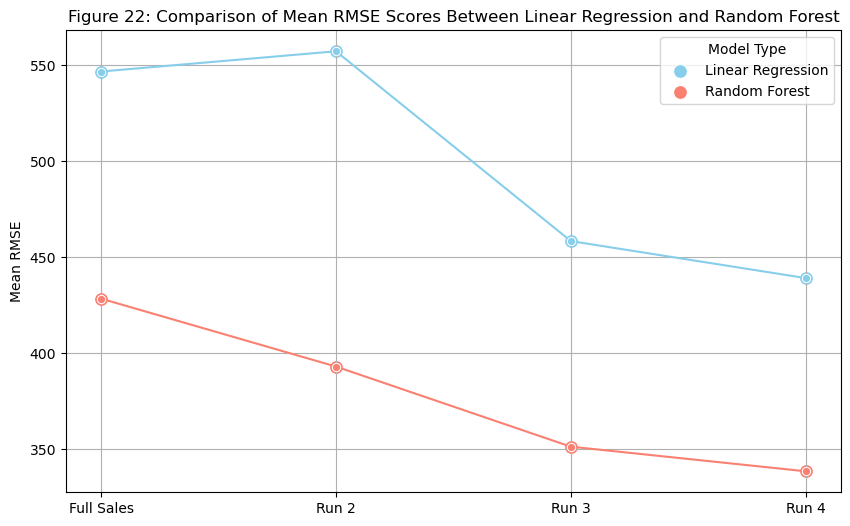

Armse_scores: [549.9164634311707, 545.4416391902482, 544.6401111428601, 546.3309513042561, 547.1693526331694]
A1rmse_scores: [553.0819003591179, 561.1345752328291, 552.6385685052288, 561.8074480749974, 557.5561093197932]
A2rmse_scores: [455.52852995727807, 456.3815841000054, 458.86445112290625, 458.4717026598188, 462.5689252700881]
A3rmse_scores: [448.5237638923869, 436.4219310444445, 444.5925182188577, 437.99947040198623, 427.89301229976394]
Brmse_scores: [429.2298187834211, 427.9918794397498, 428.292448247913, 426.79238545693175, 429.4866905440316]
B1rmse_scores: [387.66853537130436, 393.7355261738371, 390.9006542548435, 395.42940764753513, 397.19781286185184]
B2rmse_scores: [349.93074093928954, 349.3869577070663, 351.1766929207938, 351.0593982830886, 354.6942146434944]
B3rmse_scores: [343.74818436048946, 338.3465625705447, 343.02911534366376, 340.1985819677995, 326.8297220650665]


In [32]:
#Plot RMSE values for Linear Regression and Random Forest to find the optimal model

A_means = [np.mean(Armse_scores), np.mean(A1rmse_scores), np.mean(A2rmse_scores), np.mean(A3rmse_scores)]
B_means = [np.mean(Brmse_scores), np.mean(B1rmse_scores), np.mean(B2rmse_scores), np.mean(B3rmse_scores)]

# Labels for each run
labels = ['Full Sales', 'Run 2', 'Run 3', 'Run 4']

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x=labels, y=A_means, color='skyblue', s=100, label='Linear Regression')
sns.scatterplot(x=labels, y=B_means, color='salmon', s=100, label='Random Forest')

# Draw trend lines
sns.lineplot(x=labels, y=A_means, color='skyblue', marker='o')
sns.lineplot(x=labels, y=B_means, color='salmon', marker='o')

plt.title('Figure 22: Comparison of Mean RMSE Scores Between Linear Regression and Random Forest')
plt.ylabel('Mean RMSE')
plt.legend(title='Model Type')
plt.grid(True)
plt.show()

#Display RMSE values
print("Armse_scores:", Armse_scores)
print("A1rmse_scores:", A1rmse_scores)
print("A2rmse_scores:", A2rmse_scores)
print("A3rmse_scores:", A3rmse_scores)
print("Brmse_scores:", Brmse_scores)
print("B1rmse_scores:", B1rmse_scores)
print("B2rmse_scores:", B2rmse_scores)
print("B3rmse_scores:", B3rmse_scores)

#### Model Performance
The Random Forest model outperformed Linear Regression in predicting sales levels across all segments. This model is recommended for ongoing sales predictions due to its ability to handle complex, non-linear relationships within the data.

## Results and Recommendations

#### 1. Customer Segmentation Model
- **Clusters Identified**: The unsupervised learning model identified four optimal clusters based on customer demographics and purchasing behavior (see Figure 13), as suggested by the elbow method (see Figure 12). Each cluster represents a distinct segment of the customer base, characterized by age groups and product category preferences:

- **Cluster 0 (Ages 51-87):**  
  - **Findings:** Preference for beauty, personal care, and home products, with a focus on self-care, comfort, brand loyalty, and less price sensitivity. They value quality and reliability.
  - **Insights:** Emphasize product reliability and health benefits through traditional media and targeted online campaigns. Develop products that focus on ease of use, ergonomics, and health-oriented features.


- **Cluster 1 (Ages 31-50):**  
  - **Findings:** Interest in home and food products, driven by the balance of family life and career, with a focus on value, convenience, and quality.
  - **Insights:** Highlight product efficiency, family benefits, and cost-effectiveness, especially during key seasons. Develop multi-functional or eco-friendly home products and time-saving meal solutions.


- **Cluster 2 (Ages 21-40):**  
  - **Findings:** Strong inclination towards electronics and food, driven by tech-savviness, convenience, and trend-following, with less brand loyalty and a preference for online shopping.
  - **Insights:** Utilize social media, influencer partnerships, and highlight trendy product features. Innovate in smart home tech and health-oriented convenience foods.


- **Cluster 3 (Ages 0-30):**  
  - **Findings:** Interest in electronics and beauty/personal care products, with a focus on innovation, personal image, price sensitivity, and strong social media influence.
  - **Insights:** Focus on visually appealing ads on social platforms, use promotions and discounts. Develop affordable, trendy electronics, and eco-friendly beauty products.

**Overlapping Age Groups**: For the model going forward, the clusters were consolidated from 4 to 3. This decision was due to overlapping age groups. Cluster 2 has age groups that overlaps with Cluster 3 and Cluster 1. This approach is to streamline the model and focus on distinct segments that exhibit unique purchasing patterns.

<br>

#### 2. Sales Prediction Model
- **Model Performance**: The Random Forest model outperformed Linear Regression in predicting sales levels across all segments. This model is recommended for ongoing sales predictions due to its ability to handle complex, non-linear relationships within the data.
- **Cluster 1**: Young and youngest demographics show significantly improved prediction accuracy in the Random Forest model, likely due to the model's ability to handle the variability and complexities of younger consumer behavior.
- **Cluster 2**: The middle-aged segment also demonstrated better results with Random Forest, suggesting that this model is more adept at forecasting for groups with varied product interests.
- **Cluster 3**: The oldest demographic showed the most substantial improvement in prediction accuracy with Random Forest, underscoring its effectiveness in dealing with segments that may have more stable but diverse purchasing patterns.


## Future Work

- **Explore Alternative Predictive Models**: Investigate advanced models like XGBoost, LightGBM, or neural networks for potentially improved accuracy.
- **Continuous Model Tuning**: Periodically reevaluate and fine-tune models to adapt to changing customer behaviors and market conditions.
- **Dashboard Development**: Develop an interactive Tableau dashboard to visualize consumer behavior and optimize business strategies.
- **Implement Tailored Marketing Strategies**: Use segmentation insights to precisely target marketing efforts, boosting engagement and sales conversions.
- **Optimize Inventory Management**: Use predictive insights to align inventory with demand, reducing both overstocks and stockouts.

    #### Future Questions to Explore
    - How do external factors such as economic changes, market trends, and seasonal effects influence customer purchasing behaviors and model predictions?
    - How does brand loyalty vary across different customer segments and how can this influence new product launches or rebranding efforts?
    - How do our products perform in comparison to competitors within each customer segment?
    - Can we track changes in customer behavior over time to predict future trends more accurately?
    - What improvements can be made by integrating real-time data feeds into the prediction models to capture up-to-the-minute trends and behaviors?
    - Can analyzing customer feedback and sentiment provide deeper insights into the effectiveness of current marketing strategies and product positioning?
        
    By acting on these insights and exploring these questions, this online retail business can not only enhance its operational efficiency and drive better customer engagement but also maintain a competitive edge in a rapidly evolving market landscape.


## Next Steps

The next phase involves developing an interactive Tableau dashboard to:
- Visualize Consumer Behavior
- Optimize Marketing Spend
- Manage Inventory
- Implement Targeted Discount Strategies
- Enhance strategic decision-making and operational efficiency

This dashboard will streamline operations, enhance strategic decisions, and contribute to sustained business growth by providing a comprehensive overview of key business metrics.